## Imports and Helper functions

In [1]:
import numpy as np
import pynq
import matplotlib.pyplot as plt
import json
import math
import time

import utils
import benchmarking_utils as bu
import autoencoder_alveo
import cpu_power_scraper

import torch
import models.rae

def plot_timeseries(benign_timeseries, malicious_timeseries):
    plt.figure(figsize=(12, 8))

    # Plotting benign data
    plt.subplot(2, 1, 1)
    plt.plot(benign_timeseries, label='Benign Timeseries')
    plt.title('Benign Timeseries')
    plt.xlabel('Timestep')
    plt.ylabel('ul_bitrate')
    plt.legend()
    
    # Plotting malicious data
    plt.subplot(2, 1, 2)
    plt.plot(malicious_timeseries, label='Malicious Timeseries')
    plt.title('Malicious Timeseries')
    plt.xlabel('Timestep')
    plt.ylabel('ul_bitrate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_timeseries_cpu(benign_timeseries, malicious_timeseries, benign_output_cpu, malicious_output_cpu):
    # Create the figure and adjust layout for vertical stacking
    plt.figure(figsize=(12, 8))
    
    # Plotting benign data
    plt.subplot(2, 1, 1)
    plt.plot(benign_timeseries, label='Benign Timeseries')
    plt.plot(benign_output_cpu, label='CPU Output')
    plt.title('Benign Timeseries vs. Output')
    plt.xlabel('Timestep')
    plt.ylabel('ul_bitrate')
    plt.legend()
    
    # Plotting malicious data
    plt.subplot(2, 1, 2)
    plt.plot(malicious_timeseries, label='Malicious Timeseries')
    plt.plot(malicious_output_cpu, label='CPU Output')
    plt.title('Malicious Timeseries vs. Output')
    plt.xlabel('Timestep')
    plt.ylabel('ul_bitrate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_timeseries_cpu_alveo(benign_timeseries, malicious_timeseries, benign_output_cpu, malicious_output_cpu, benign_output_alveo, malicious_output_alveo):
    # Create the figure and adjust layout for vertical stacking
    plt.figure(figsize=(12, 8))
    
    # Plotting benign data
    plt.subplot(2, 1, 1)
    plt.plot(benign_timeseries, label='Benign Timeseries')
    plt.plot(benign_output_cpu, label='CPU Output')
    plt.plot(benign_output_alveo, label='Alveo Output')
    plt.title('Benign Timeseries vs. Output')
    plt.xlabel('Timestep')
    plt.ylabel('ul_bitrate')
    plt.legend()
    
    # Plotting malicious data
    plt.subplot(2, 1, 2)
    plt.plot(malicious_timeseries, label='Malicious Timeseries')
    plt.plot(malicious_output_cpu, label='CPU Output')
    plt.plot(malicious_output_alveo, label='Alveo Output')
    plt.title('Malicious Timeseries vs. Output')
    plt.xlabel('Timestep')
    plt.ylabel('ul_bitrate')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('timeseries_output.png', format='png', dpi=300)  # Saves the plot with high resolution
    plt.show()

def load_cpu_model(AE_PARAMETERS_PATH, MODEL_STATE_DICT_PATH):
    # Load the JSON file
    with open(AE_PARAMETERS_PATH, 'r') as file:
        exp_parameters = json.load(file)
    
    rae_model = models.rae.LSTMAutoencoder(
        input_dim = len(exp_parameters['feature_columns']), 
        hidden_dim1 = exp_parameters['parameters']['hidden_dim1'], 
        hidden_dim2 = exp_parameters['parameters']['hidden_dim2'], 
        output_dim = len(exp_parameters['feature_columns']), 
        dropout = exp_parameters['parameters']['dropout'], 
        layer_norm_flag = exp_parameters['parameters']['layer_norm_flag']
    )
    
    rae_model.load_state_dict(torch.load(MODEL_STATE_DICT_PATH, map_location=torch.device('cpu')))
    rae_model.eval()
    print("Succesfully loaded CPU model!")
    return rae_model

def benchmark_cpu_model(rae_model, cpu_input_vector, ITERATIONS):
    total_time = 0
    for i in range(ITERATIONS):
        start = time.perf_counter()
        _ = rae_model(cpu_input_vector)
        end = time.perf_counter()
        total_time += end - start
    print(f"Average CPU model run: {total_time/ITERATIONS*1000:.2f} ms")

/usr/local/lib/python3.8/dist-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/usr/local/lib/python3.8/dist-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


##  Load Timeseries

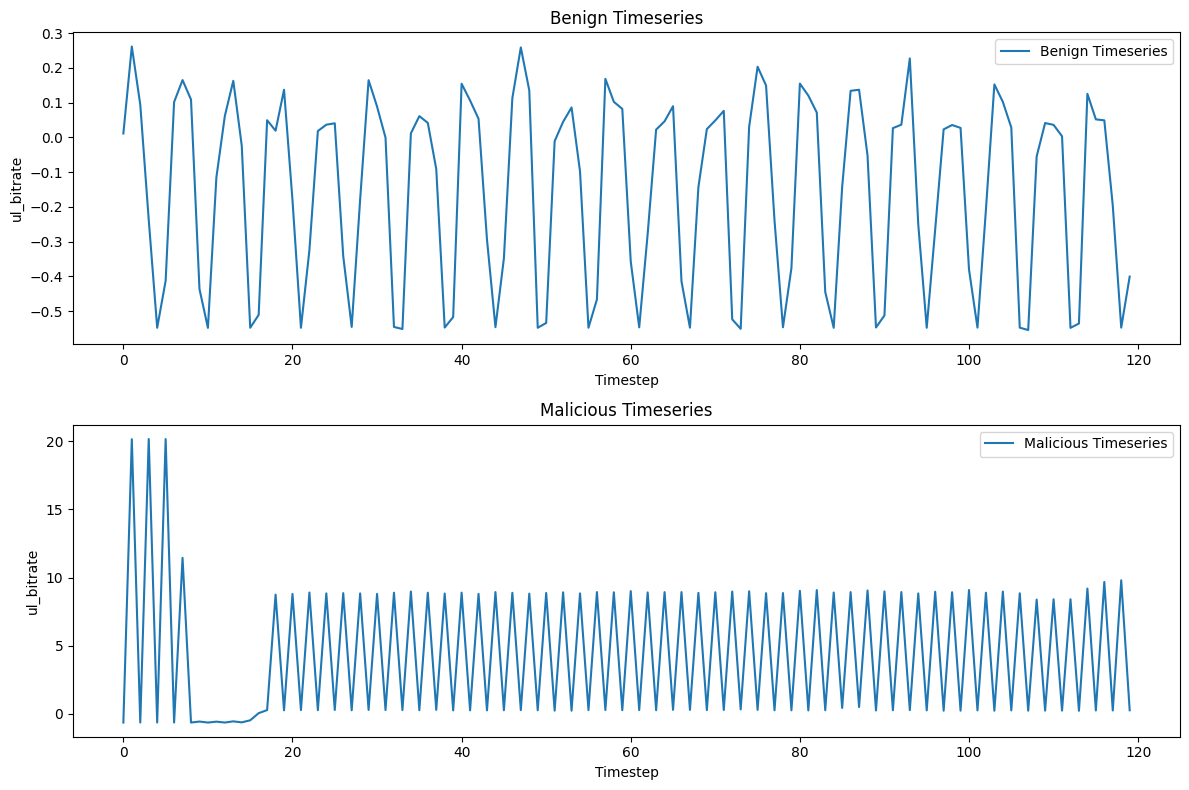

In [2]:
# Load the JSON file
with open("/setup_dir/Alveo-PYNQ/mounted_dir/timeseries.json", 'r') as file:
    data = json.load(file)

# Extract the timeseries data and convert them to numpy arrays
benign_timeseries = np.array(data['benign_timeseries_ul_bitrate'], dtype=np.float32)
malicious_timeseries = np.array(data['malicious_timeseries_ul_bitrate'], dtype=np.float32)

plot_timeseries(benign_timeseries, malicious_timeseries)

## Load CPU model

In [3]:
AE_PARAMETERS_PATH = "/setup_dir/Alveo-PYNQ/mounted_dir/privateer_ae_parameters.json"
MODEL_STATE_DICT_PATH = "/setup_dir/Alveo-PYNQ/mounted_dir/rae_model_privateer_2.pth"
rae_model = load_cpu_model(AE_PARAMETERS_PATH, MODEL_STATE_DICT_PATH)

Succesfully loaded CPU model!


### Benchmarking

In [4]:
ITERATIONS=1000
cpu_input_vector = torch.from_numpy(benign_timeseries).view(1, -1, 1)
benchmark_cpu_model(rae_model, cpu_input_vector, ITERATIONS)

Average CPU model run: 4.43 ms


### Plot Timeseries and Autoencoder CPU Predictions

Average benign difference: 0.04756930343185862
Average malicious differencce:4.102129586289326


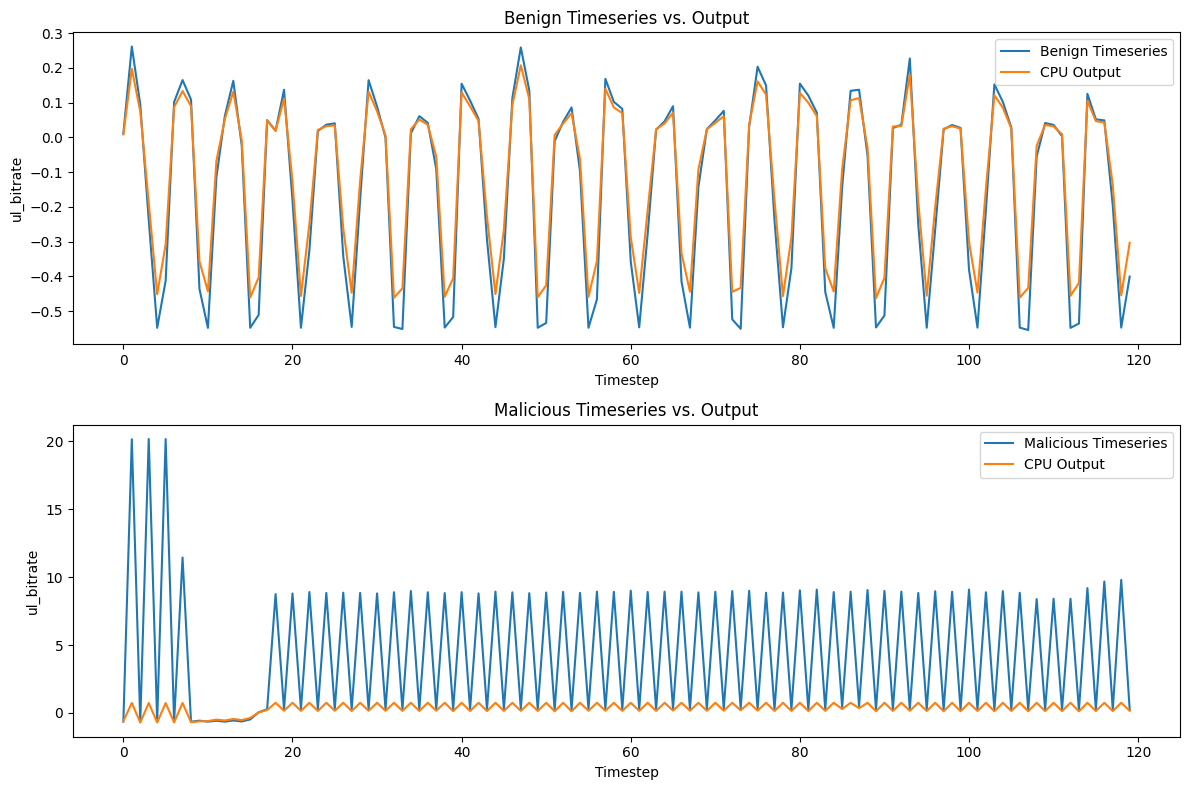

In [5]:
with torch.no_grad():
    benign_output_cpu = rae_model(torch.from_numpy(benign_timeseries).view(1, -1, 1)).numpy().reshape(-1)
    malicious_output_cpu = rae_model(torch.from_numpy(malicious_timeseries).view(1, -1, 1)).numpy().reshape(-1)

print(f"Average benign difference: {utils.get_average_difference(benign_timeseries, benign_output_cpu)}")
print(f"Average malicious differencce:{utils.get_average_difference(malicious_timeseries, malicious_output_cpu)}")

plot_timeseries_cpu(benign_timeseries, malicious_timeseries, benign_output_cpu, malicious_output_cpu)

## Check FPGA Devices

In [6]:
devices = pynq.Device.devices
for i in range(len(devices)):
    print("{}) {}".format(i, devices[i].name))

0) xilinx_u280_xdma_201920_3


## Load Autoencoder on ALVEO

In [7]:
AE_XCLBIN_PATH = "/setup_dir/Alveo-PYNQ/mounted_dir/lstm.xclbin"
device = pynq.Device.devices[0]
ae_parameters = autoencoder_alveo.AutoencoderParameters()
ae_alveo = autoencoder_alveo.AutoencoderAlveo(AE_XCLBIN_PATH, ae_parameters, device)

Initialized
Allocated Buffers
Succesfully loaded ALVEO model!


### Benchmarking

In [8]:
ITERATIONS=1000
input_vector = benign_timeseries[:ae_alveo.in_out_size]
for i in range(ITERATIONS):
    _ = ae_alveo.timed_run(input_vector, verbose=False)
ae_alveo.print_timings()

Initialize time: 429.46 ms
Allocate buffers time: 0.40 ms
Average run: 0.49 ms
Number of runs: 1000


### Plot Timeseries and Autoencoder ALVEO predictions

Average benign difference: 0.08665022560550521
Average malicious differencce:4.844898793846369


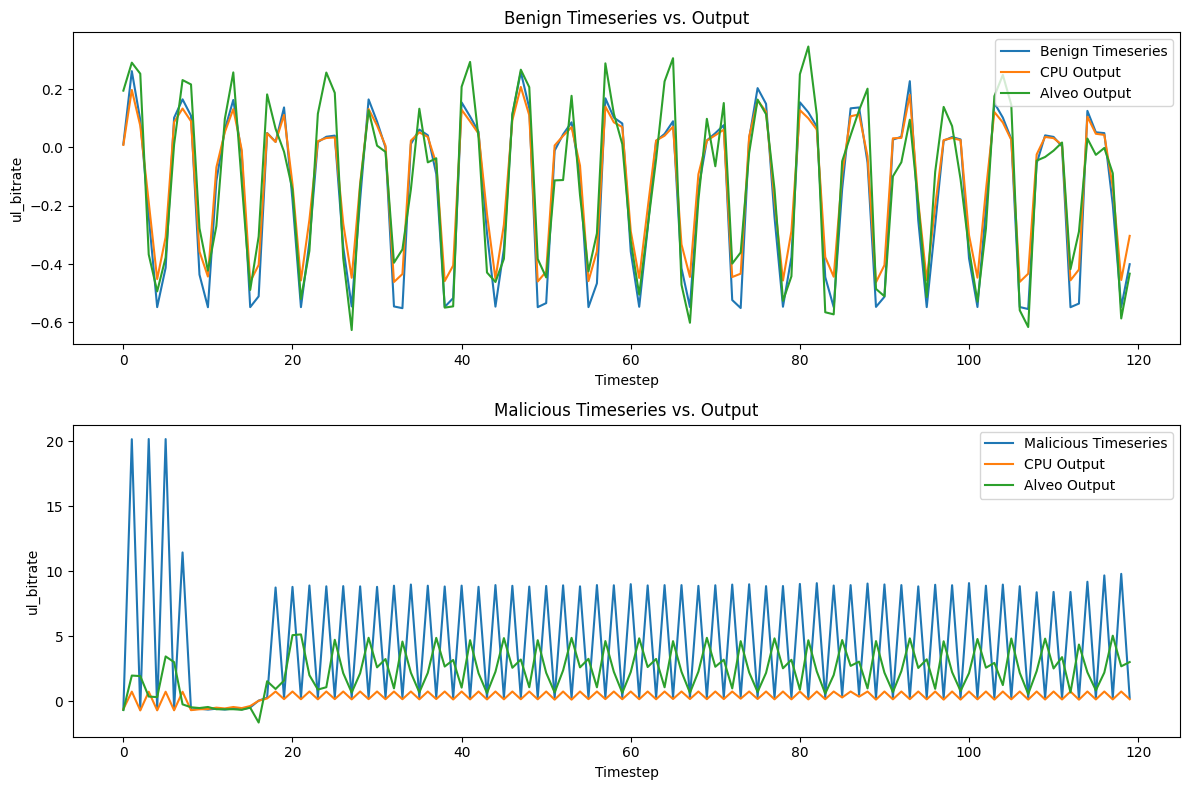

In [9]:
benign_output_alveo = ae_alveo.run_vector(benign_timeseries)
malicious_output_alveo = ae_alveo.run_vector(malicious_timeseries)

print(f"Average benign difference: {utils.get_average_difference(benign_timeseries, benign_output_alveo)}")
print(f"Average malicious differencce:{utils.get_average_difference(malicious_timeseries, malicious_output_alveo)}")

plot_timeseries_cpu_alveo(benign_timeseries, malicious_timeseries, benign_output_cpu, malicious_output_cpu, benign_output_alveo, malicious_output_alveo)

### Get CPU Power Measurements

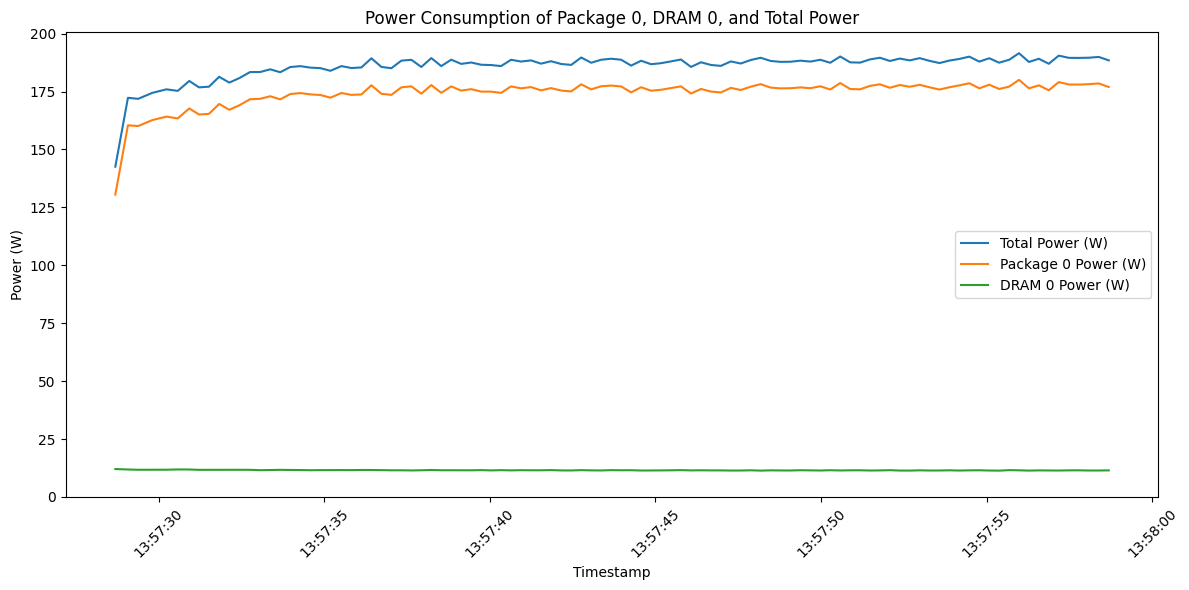

Average Total Power: 185.99 W


In [10]:
cpu_power = cpu_power_scraper.power_scraper(rae_model)
cpu_input_vector = torch.from_numpy(benign_timeseries).view(1, -1, 1)
cpu_df = cpu_power.get_power_data(cpu_input_vector, 30)
bu.plot_cpu_power_data(cpu_df)
print(f"Average Total Power: {cpu_df['total_power_w'].mean():.2f} W")

### Get ALVEO Power Measurements

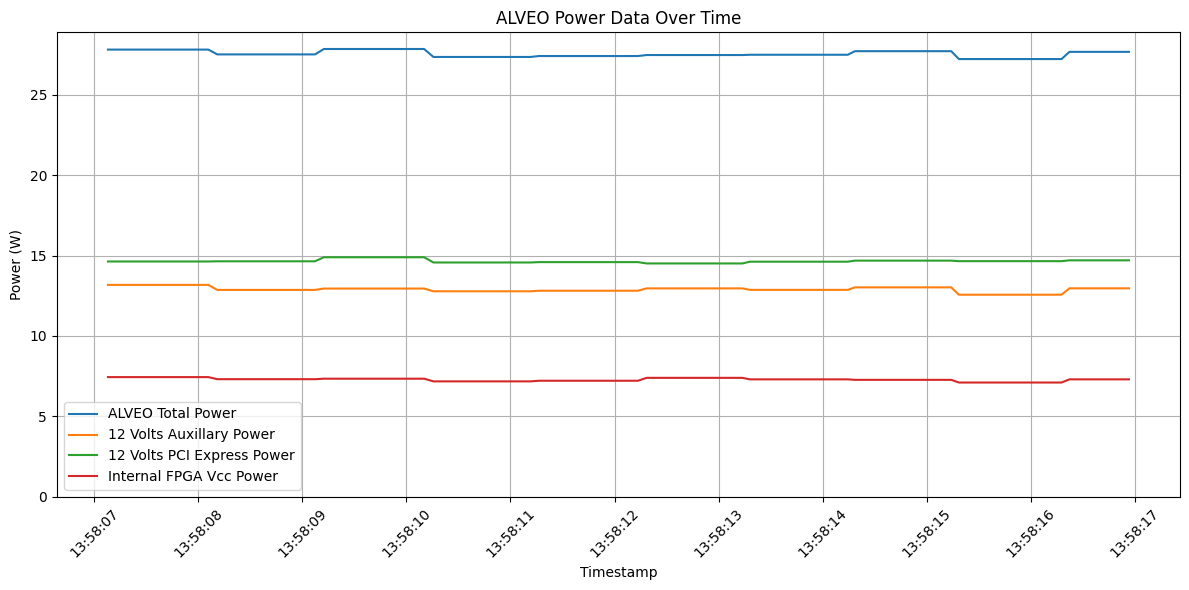

Average ALVEO Total Power: 27.53 W


In [11]:
data = ae_alveo.get_power_data(seconds=10)
alveo_df = bu.extract_alveo_power_data(data)
bu.plot_alveo_power_data(alveo_df)
print(f"Average ALVEO Total Power: {alveo_df['Power'].mean():.2f} W")